In [ ]:
import warnings

import df_utils as utils
from df_model import (
    CLF_DECISION_TREE,
    CLF_LOGISTIC_REGRESSION,
    CLF_SUPPORT_VECTOR,
    PIPE_CLASSIFIER,
    PIPE_ENCODER,
    PIPE_IMPUTER,
    PIPE_SCALER,
    PIPE_SELECTOR,
    PIPE_TRANSFORMER,
    DataModel,
)
# from sklearnex import patch_sklearn # pip install scikit-learn-intelex

In [ ]:
############ PRODUCTION SETTINGS ############

# optimize scikit runtime for intel processor
# patch_sklearn() # uncomment if installed

# ignore unproblematic parameter warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
%%capture
# run preprocessing notebook
%run df1_dcredit_prep.ipynb

In [4]:
############ CONFIGURATION ############

# list desired settings
data_config = {
    "dataset": "default_credit",
    "index": "ID",
    "target": "default",
    "has_imbalance": True,
    "has_test": False,
    "use_raw": False,
    "n_folds": 2,
    "scoring": "f1_weighted",
    "cv_random": True,
    "cv_iter": 2,
}

# choose desired final classifiers and pipeline modelling steps
final_models = {
    CLF_LOGISTIC_REGRESSION: [PIPE_ENCODER, PIPE_TRANSFORMER, PIPE_SCALER, PIPE_SELECTOR],
    CLF_SUPPORT_VECTOR: [PIPE_ENCODER, PIPE_TRANSFORMER, PIPE_SCALER, PIPE_SELECTOR],
    CLF_DECISION_TREE: [PIPE_ENCODER, PIPE_IMPUTER, PIPE_TRANSFORMER, PIPE_SCALER, PIPE_SELECTOR, PIPE_CLASSIFIER],
}

# pipeline steps: encoders, imputers, transformers, scalers, feature selectors, classifiers
[PIPE_ENCODER, PIPE_IMPUTER, PIPE_TRANSFORMER, PIPE_SCALER, PIPE_SELECTOR, PIPE_CLASSIFIER]

['enc', 'imp', 'trf', 'scl', 'fsl', 'clf']

In [5]:
# import data set
(data, data_test) = utils.import_data(data_config["dataset"], data_config["has_test"], data_config["use_raw"])

importing from: data/data_clean/default_credit.csv


In [6]:
# set data index
data = utils.set_data_index(data, data_config["index"])
if data_config["has_test"]:
    data_test = utils.set_data_index(data_test, data_config["index"])

In [7]:
############ MODELLING ############

# create data set model
data_model = DataModel(data, data_config["target"], data_test, data_config["has_imbalance"], data_config["n_folds"])

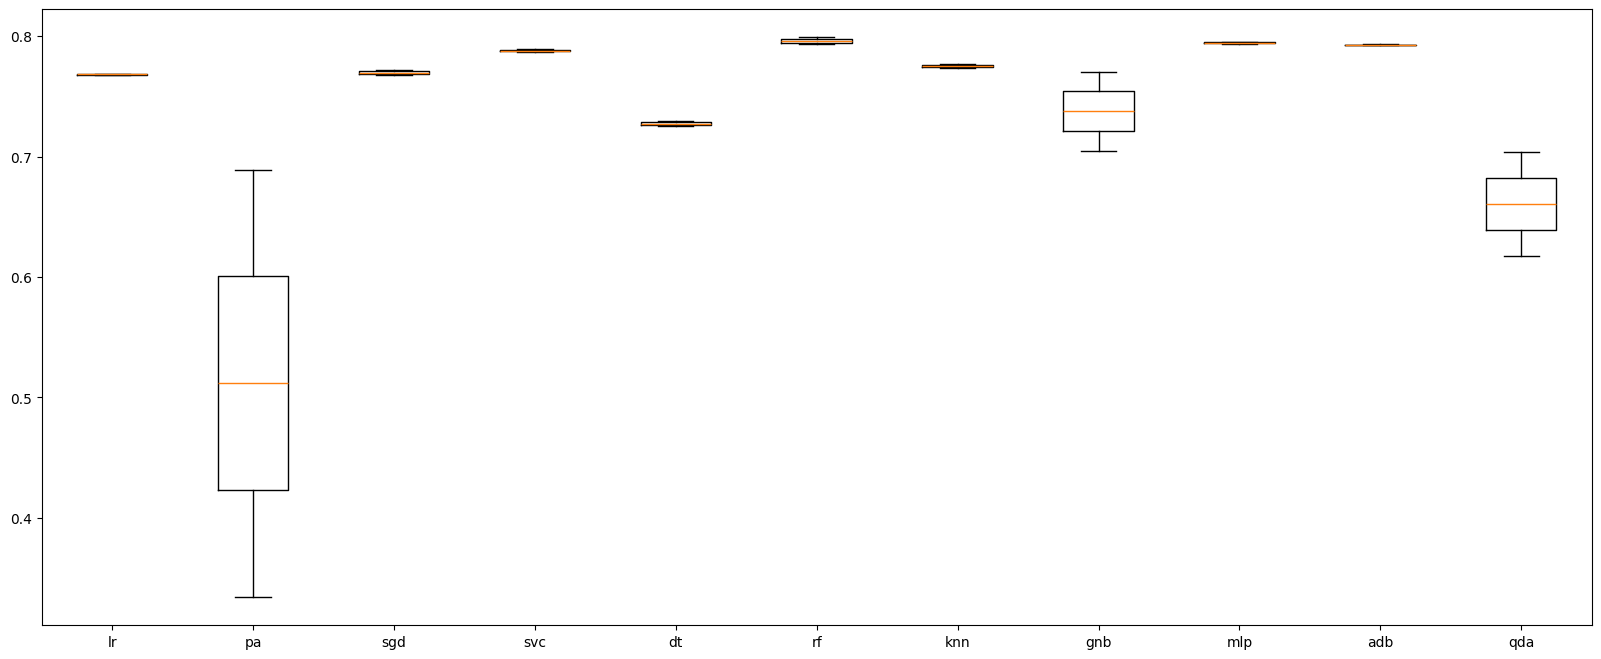

In [8]:
############ CLASSIFIER SELECTION ############

# plot classifier performance on training data out of the box
data_model.plot_models_train_performance(scale=True, encode=True)

In [9]:
# print classifier performance on test data out of the box
data_model.print_models_test_performance(scale=True, encode=True)

lr - accuracy: 0.8106666666666666 / f1: 0.7710462508827941
pa - accuracy: 0.7986666666666666 / f1: 0.7443369823259354
sgd - accuracy: 0.8093333333333333 / f1: 0.7700138700679438
svc - accuracy: 0.8196666666666667 / f1: 0.7911161736344972
dt - accuracy: 0.721 / f1: 0.7206219231759414
rf - accuracy: 0.8156666666666667 / f1: 0.7938359943521234
knn - accuracy: 0.7983333333333333 / f1: 0.7797821902176052
gnb - accuracy: 0.732 / f1: 0.7449264033264034
mlp - accuracy: 0.8203333333333334 / f1: 0.7941197397627248
adb - accuracy: 0.8203333333333334 / f1: 0.7932402341718049
qda - accuracy: 0.635 / f1: 0.6659455680200199


In [10]:
############ HYPERPARAMETER TUNING ############

# tune the parameters of the chosen final classifiers and pipeline steps
optimal_models = {}
for classifier_name, model_steps in final_models.items():
    print(f"---------current model: {classifier_name}---------")
    optimal_models[classifier_name] = data_model.train_model_classifier(classifier_name, model_steps, random=data_config["cv_random"], n_iter=data_config["cv_iter"], performance=data_config["scoring"])

---------current model: lr---------
tuned enc score: 0.6820620115892019
tuned trf score: 0.682706070993604
tuned scl score: 0.771705459408877
tuned fsl score: 0.7673949056702287
---------current model: svc---------
tuned enc score: 0.6819737622189526
tuned trf score: 0.6820620115892019
tuned scl score: 0.7954659442824856
tuned fsl score: 0.7965624798713407
---------current model: dt---------
tuned enc score: 0.7275715355283259
tuned imp score: 0.7275715355283259
tuned trf score: 0.7286385767065406
tuned scl score: 0.7286093415316428
tuned fsl score: 0.7940195452345502
tuned clf score: 0.7824725845309703


In [11]:
############ MODEL EVALUATION ############

# display the produced model pipelines
for model in optimal_models.values():
    display(model)

Pipeline(steps=[('enc',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object')),
                                                 ('numerical', 'passthrough',
                                                  Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_...
      dtype='object'))])),
                ('imp', 'passthrough'),
                ('trf',
                 ColumnTransformer(transformers=[('positive',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  array([ 0,  1,  2,  3,  4, 15, 16, 17, 18, 19, 20])),
                                                 ('negative', 'passthrough',
                                                  array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))])),
                ('scl', StandardScaler()), ('fsl', SelectKBest()),
                ('clf',
                 LogisticRegression(max_iter=500, random_state=42,
                                    solver='saga'))])

Pipeline(steps=[('enc',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object')),
                                                 ('numerical', 'passthrough',
                                                  Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object'))])),
                ('imp', 'passthrough'),
                ('trf',
                 ColumnTransformer(transformers=[('positive',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  array([ 0,  1,  2,  3,  4, 15, 16, 17, 18, 19, 20])),
                                                 ('negative', 'passthrough',
                                                  array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))])),
                ('scl', StandardScaler()), ('fsl', SelectKBest()),
                ('clf', SVC(random_state=42))])

Pipeline(steps=[('enc',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object')),
                                                 ('numerical', 'passthrough',
                                                  Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_...
                 ColumnTransformer(transformers=[('positive',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  array([ 0,  1,  2,  3,  4, 15, 16, 17, 18, 19, 20])),
                                                 ('negative', 'passthrough',
                                                  array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))])),
                ('scl', StandardScaler()), ('fsl', SelectKBest(k=4)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='log_loss', max_depth=4,
                                        max_features='sqrt',
                                        random_state=42))])

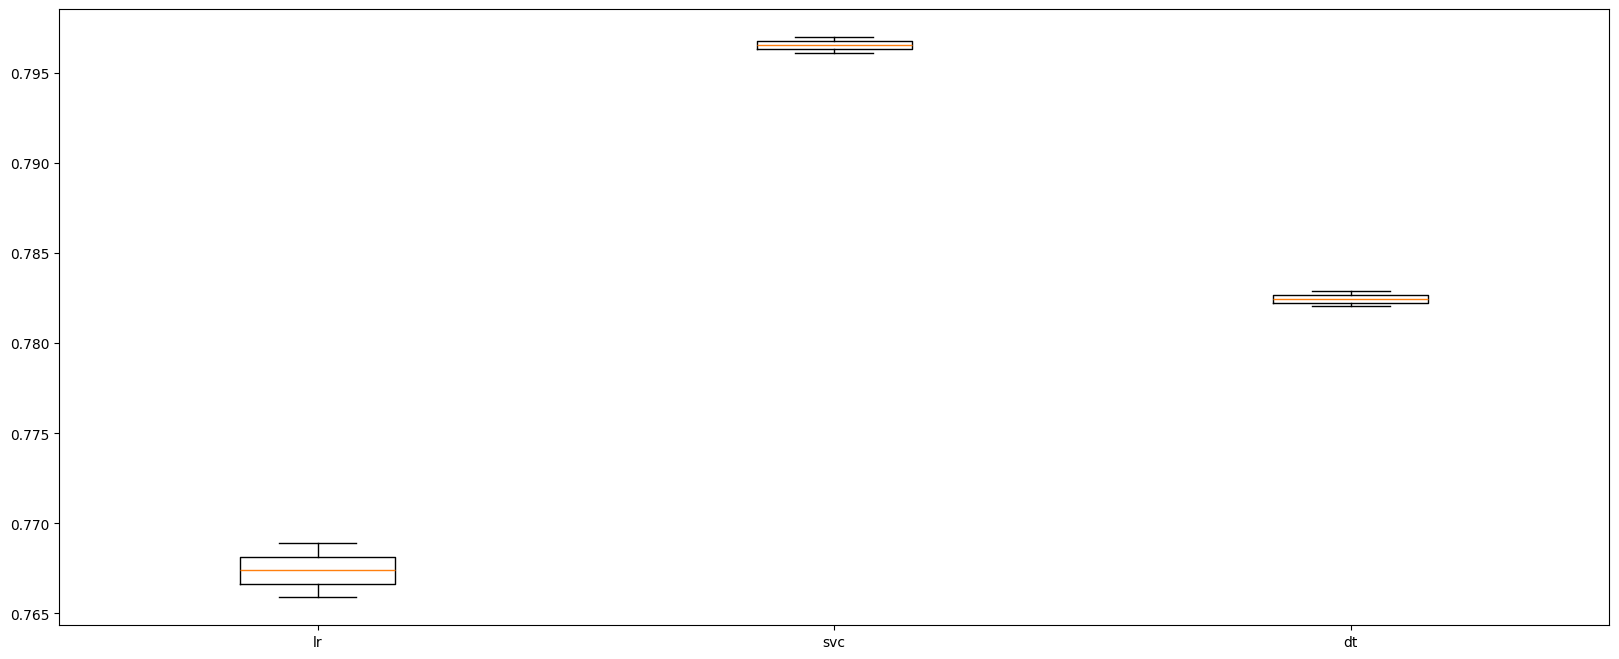

In [12]:
# check for train classifier performance with optimized settings
data_model.plot_models_train_performance(optimal_models)

In [13]:
# check for test classifier performance with optimized settings
data_model.print_models_test_performance(optimal_models)

lr - accuracy: 0.8046666666666666 / f1: 0.7649729266987694
svc - accuracy: 0.8223333333333334 / f1: 0.7989219757650071
dt - accuracy: 0.787 / f1: 0.7896609478891419


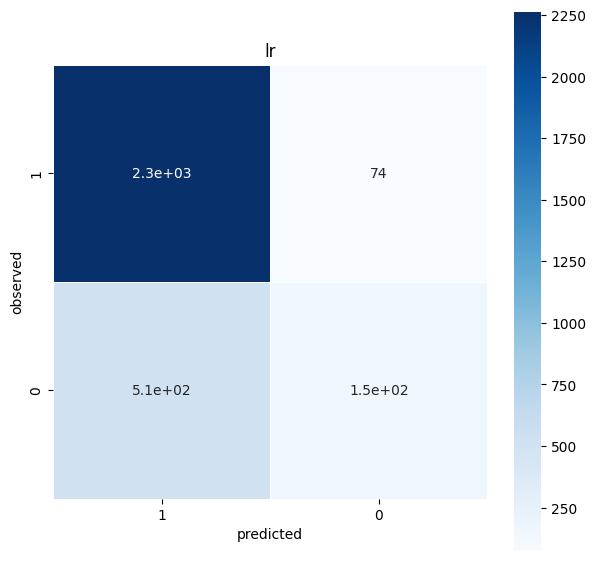

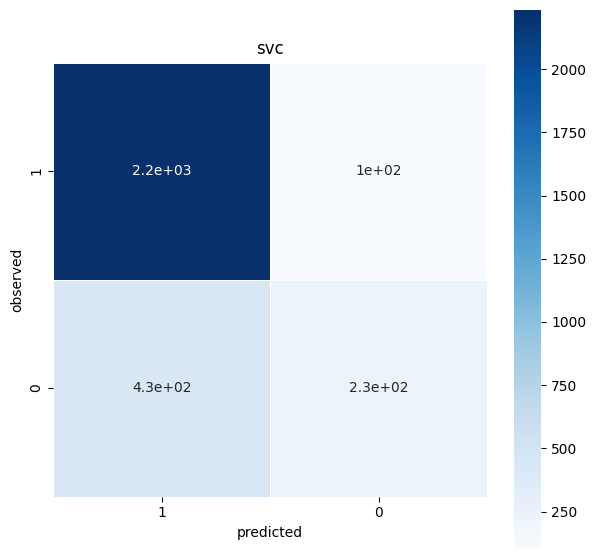

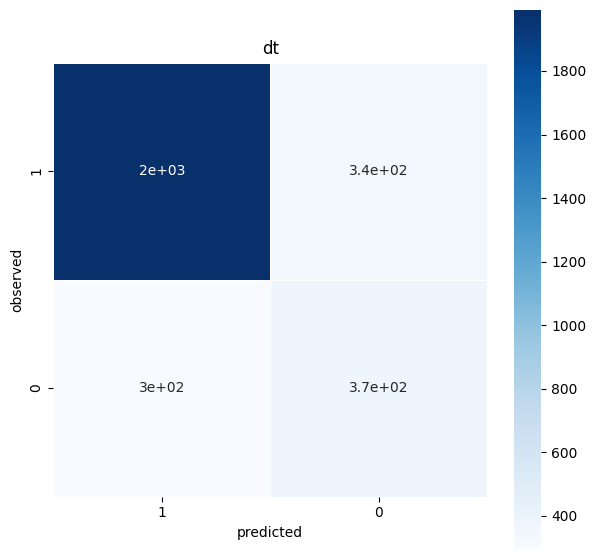

In [14]:
# visualize confusion matrix of models on test data
data_model.plot_models_test_cmatrix(optimal_models)

In [15]:
############ KAGGLE HAND-IN ############

# prepare final prediction on new test data
if data_config["has_test"]:
    for model_name, model in optimal_models.items():
        data_test_fin = data_model.fit_model_newdata(model)
        utils.export_data(data_test_fin, data_config["dataset"] + "_" + model_name, predict=True)

        display(data_test_fin)